# Setup and data download

In [22]:
import yfinance as yf
import pandas as pd
import datetime
import numpy as np
from scipy import stats
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import yahooquery as yq
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import tqdm
sns.set_style("whitegrid")
DARK_COL = "#6876a4"
LIGHT_COL = "#f0b64d"

In [4]:
######### Load fama french data ###########
ff = pd.read_csv("F-F_Research_Data_5_Factors_2x3_daily.csv")
ff = ff.rename({"Unnamed: 0": "Date"}, axis = 1)
ff["Date"] = pd.to_datetime(ff["Date"], format="ISO8601")
#ff["Rm-Rf"] = ff["Mkt-RF"] - ff["RF"]
ff

,Date,Mkt-RF,SMB,HML,RMW,CMA,RF
0,1963-07-01,-0.67,0.02,-0.35,0.03,0.13,0.012
1,1963-07-02,0.79,-0.28,0.28,-0.08,-0.21,0.012
2,1963-07-03,0.63,-0.18,-0.10,0.13,-0.25,0.012
3,1963-07-05,0.40,0.09,-0.28,0.07,-0.30,0.012
4,1963-07-08,-0.63,0.07,-0.20,-0.27,0.06,0.012
...,...,...,...,...,...,...,...
15036,2023-03-27,0.27,0.51,1.02,-0.28,0.35,0.016
15037,2023-03-28,-0.17,-0.03,0.74,0.08,0.55,0.016
15038,2023-03-29,1.39,-0.34,-0.50,-0.90,-0.54,0.016
15039,2023-03-30,0.51,-0.61,-0.59,0.20,-0.09,0.016


In [5]:
######### Get returns of S&P 500 stocks ###########

# Get tickers of S&P 500
def list_wikipedia_sp500() -> pd.DataFrame:
    # Ref: https://stackoverflow.com/a/75845569/
    url = 'https://en.m.wikipedia.org/wiki/List_of_S%26P_500_companies'
    return pd.read_html(url, attrs={'id': 'constituents'}, index_col='Symbol')[0]

tickers = list(list_wikipedia_sp500().index) + ["^GSPC"]

# Download data from 2010 onwards up to last day of FF
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2023, 4, 1) # Last day of FF
data = yf.download(tickers, start = start, end = end)
prices = data["Adj Close"].reset_index()
# Drop columns without any data
prices = prices.drop(["BF.B", "BRK.B", "HON"], axis=1)

# Compute log-prices and log-returns
returns = prices.copy()
returns.iloc[:,1:] = np.log(prices.iloc[:,1:])
Returns = np.diff(returns.iloc[:,1:],axis=0)*100  #times 100 so we get returns in percentage 
# We assume the first return to be 0
Returns = np.vstack((np.zeros(Returns.shape[1]),Returns))
returns.iloc[:,1:] = Returns
# Isolate S&P 500
sp500 = returns[["Date","^GSPC"]]
returns = returns.drop("^GSPC", axis = 1)
returns

[*********************100%***********************]  504 of 504 completed

2 Failed downloads:
- BRK.B: No timezone found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted


,Date,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
0,2010-01-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2010-01-05,-1.092223,10.724573,-0.596086,0.172755,NaN,-0.716037,-0.811254,-0.334110,0.616112,...,5.904136,-1.193024,0.389710,-1.195954,NaN,-0.342566,3.116542,-0.174548,3.465116,NaN
2,2010-01-06,-0.355927,-4.231421,0.868204,-1.603397,NaN,-0.950057,0.553847,-0.433244,1.057464,...,-1.320371,0.191839,0.860590,0.656688,NaN,-0.717495,-0.032311,-0.771667,8.338190,NaN
3,2010-01-07,-0.129704,2.904349,-0.024744,-0.185038,NaN,-1.616647,0.824997,-0.589966,-0.093564,...,2.113127,-0.432180,-0.314723,1.300556,NaN,-0.028801,2.268106,-2.531778,10.616014,NaN
4,2010-01-08,-0.032500,-1.926830,0.394430,0.662630,NaN,1.080672,0.509940,-0.197437,-0.398529,...,-0.719062,0.048104,-0.401919,0.000000,NaN,0.028801,-2.122816,-0.325557,-1.631954,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3329,2023-03-27,0.837650,1.590773,3.467113,-1.236952,-0.304236,0.178861,0.417280,0.498369,0.717993,...,-0.225442,-0.397436,2.168911,0.748858,0.828295,0.359200,-0.031742,0.045006,3.751748,0.927596
3330,2023-03-28,-0.331202,0.286533,0.867762,-0.398826,0.449672,0.832565,-1.380599,0.645697,0.378905,...,0.814805,0.168338,1.239921,0.584490,0.561740,0.163563,0.301711,0.445592,2.091842,-0.405149
3331,2023-03-29,0.915649,2.612226,1.551751,1.959749,-0.158096,0.612047,1.542968,1.470951,1.780423,...,1.701700,1.728100,1.703109,-0.079490,1.499161,-0.070061,0.474533,2.036675,3.574739,-1.452560
3332,2023-03-30,0.477010,0.832759,0.897704,0.984129,-0.050655,0.232478,0.465358,0.088453,0.966943,...,-0.045864,0.554520,0.485234,2.574346,0.902496,0.713899,0.015782,4.293239,-2.412903,0.911838


In [6]:
# Merge dataframes based on date
df = pd.merge(ff, returns, on = "Date", how = "inner", suffixes=["_FF", ""])
df

,Date,Mkt-RF,SMB,HML,RMW,CMA_FF,RF_FF,A,AAL,AAP,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
0,2010-01-04,1.69,0.79,1.13,-0.17,0.21,0.000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2010-01-05,0.31,-0.41,1.24,-0.19,0.19,0.000,-1.092223,10.724573,-0.596086,...,5.904136,-1.193024,0.389710,-1.195954,NaN,-0.342566,3.116542,-0.174548,3.465116,NaN
2,2010-01-06,0.13,-0.13,0.57,-0.05,0.20,0.000,-0.355927,-4.231421,0.868204,...,-1.320371,0.191839,0.860590,0.656688,NaN,-0.717495,-0.032311,-0.771667,8.338190,NaN
3,2010-01-07,0.40,0.25,0.98,-0.69,0.22,0.000,-0.129704,2.904349,-0.024744,...,2.113127,-0.432180,-0.314723,1.300556,NaN,-0.028801,2.268106,-2.531778,10.616014,NaN
4,2010-01-08,0.33,0.32,0.01,0.22,-0.37,0.000,-0.032500,-1.926830,0.394430,...,-0.719062,0.048104,-0.401919,0.000000,NaN,0.028801,-2.122816,-0.325557,-1.631954,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3329,2023-03-27,0.27,0.51,1.02,-0.28,0.35,0.016,0.837650,1.590773,3.467113,...,-0.225442,-0.397436,2.168911,0.748858,0.828295,0.359200,-0.031742,0.045006,3.751748,0.927596
3330,2023-03-28,-0.17,-0.03,0.74,0.08,0.55,0.016,-0.331202,0.286533,0.867762,...,0.814805,0.168338,1.239921,0.584490,0.561740,0.163563,0.301711,0.445592,2.091842,-0.405149
3331,2023-03-29,1.39,-0.34,-0.50,-0.90,-0.54,0.016,0.915649,2.612226,1.551751,...,1.701700,1.728100,1.703109,-0.079490,1.499161,-0.070061,0.474533,2.036675,3.574739,-1.452560
3332,2023-03-30,0.51,-0.61,-0.59,0.20,-0.09,0.016,0.477010,0.832759,0.897704,...,-0.045864,0.554520,0.485234,2.574346,0.902496,0.713899,0.015782,4.293239,-2.412903,0.911838


# Questions

## 1. Do a regression using the Fama french factors for each stock excess returns and store the estimated coefficients, their t-statistics, and the R squared in a 500 x 13 matrix.

In [7]:
ff_columns = ["Mkt-RF", "SMB", "HML", "RMW", "CMA_FF"]
stocks = returns.columns[1:] # Excludes Date
X = df[ff_columns]
X = sm.add_constant(X)
X

,const,Mkt-RF,SMB,HML,RMW,CMA_FF
0,1.0,1.69,0.79,1.13,-0.17,0.21
1,1.0,0.31,-0.41,1.24,-0.19,0.19
2,1.0,0.13,-0.13,0.57,-0.05,0.20
3,1.0,0.40,0.25,0.98,-0.69,0.22
4,1.0,0.33,0.32,0.01,0.22,-0.37
...,...,...,...,...,...,...
3329,1.0,0.27,0.51,1.02,-0.28,0.35
3330,1.0,-0.17,-0.03,0.74,0.08,0.55
3331,1.0,1.39,-0.34,-0.50,-0.90,-0.54
3332,1.0,0.51,-0.61,-0.59,0.20,-0.09


In [8]:
X.columns

Index(['const', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA_FF'], dtype='object')

In [9]:
beta_names = [f"beta_{var}" for var in X.columns]
tvalue_names = [f"t_{var}" for var in X.columns]

df_ols_results = pd.DataFrame(np.zeros((len(stocks), 13+1)), columns = ["stock"] + beta_names + tvalue_names + ["R2"])

for i, stock in enumerate(stocks):
    # Get dependent variable y: excess returns of stock (X stays the same for every stock)
    y = df[stock] - df["RF_FF"]
    ols = sm.OLS(endog=y, exog=X, missing = "drop")
    ols_results = ols.fit()
    coefs = ols_results.params
    t_stats = ols_results.tvalues
    r2 = ols_results.rsquared
    df_ols_results.iloc[i, 0] = stock
    df_ols_results.iloc[i, 1:] = np.concatenate([coefs,t_stats,[r2]])

df_ols_results.round(3)

,stock,beta_const,beta_Mkt-RF,beta_SMB,beta_HML,beta_RMW,beta_CMA_FF,t_const,t_Mkt-RF,t_SMB,t_HML,t_RMW,t_CMA_FF,R2
0,A,-0.002,1.148,0.043,-0.177,-0.234,0.126,-0.109,57.003,1.120,-4.897,-4.607,1.814,0.556
1,AAL,-0.027,1.273,0.835,0.770,0.242,-0.355,-0.559,27.895,9.669,9.386,2.107,-2.251,0.302
2,AAP,-0.016,0.842,0.329,0.038,0.584,0.040,-0.533,29.533,6.094,0.733,8.133,0.403,0.250
3,AAPL,0.025,1.179,-0.175,-0.497,0.596,-0.023,1.188,57.955,-4.560,-13.600,11.634,-0.334,0.540
4,ABBV,0.028,0.792,-0.141,-0.129,0.082,0.369,0.967,28.304,-2.716,-2.667,1.188,3.975,0.245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,YUM,0.008,0.856,-0.031,0.042,0.328,0.066,0.372,42.408,-0.806,1.159,6.458,0.954,0.377
496,ZBH,-0.018,0.860,0.193,0.167,0.117,-0.168,-0.829,40.593,4.817,4.382,2.201,-2.300,0.399
497,ZBRA,0.006,1.202,0.417,-0.265,0.188,-0.103,0.194,41.857,7.675,-5.143,2.603,-1.043,0.417
498,ZION,-0.003,1.050,0.338,1.632,-0.552,-0.946,-0.131,45.974,7.813,39.746,-9.608,-11.994,0.642


# 2. Compute descriptive statistics for each of the 13 columns of the previous question.

In [10]:
# Get discriptive statistics of dataframe
df_ols_results.describe()

,beta_const,beta_Mkt-RF,beta_SMB,beta_HML,beta_RMW,beta_CMA_FF,t_const,t_Mkt-RF,t_SMB,t_HML,t_RMW,t_CMA_FF,R2
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,-0.001072,0.999379,0.140293,0.177709,0.089963,0.003839,-0.085116,42.773658,2.086346,4.501443,2.099366,0.440134,0.429731
std,0.033110,0.216048,0.299819,0.498203,0.324843,0.426937,0.924681,12.759236,6.125459,12.265326,5.324311,5.450582,0.134705
min,-0.086930,0.440067,-0.548381,-0.920035,-1.137032,-1.556368,-2.743256,2.348168,-15.501213,-16.779481,-19.895188,-17.911622,0.058644
25%,-0.016873,0.847334,-0.097875,-0.164749,-0.062509,-0.215519,-0.698176,34.721992,-2.328009,-4.124552,-1.062604,-2.495654,0.331104
50%,-0.001784,1.001999,0.109269,0.098084,0.148759,0.057823,-0.079937,41.245224,2.524023,2.320296,2.278898,0.685826,0.426386
75%,0.012642,1.146461,0.336663,0.388927,0.324795,0.290819,0.532678,50.602807,6.652108,8.613377,6.168727,3.649571,0.522387
max,0.324967,1.675625,1.357604,1.807275,0.888307,0.971784,2.458251,83.367672,17.323097,52.439348,14.599545,14.323298,0.783296


# 3. Compute nonparametric density estimates for each of the 13 t-statistics (you have about 500 values for each statistic) and make plots. Comment.

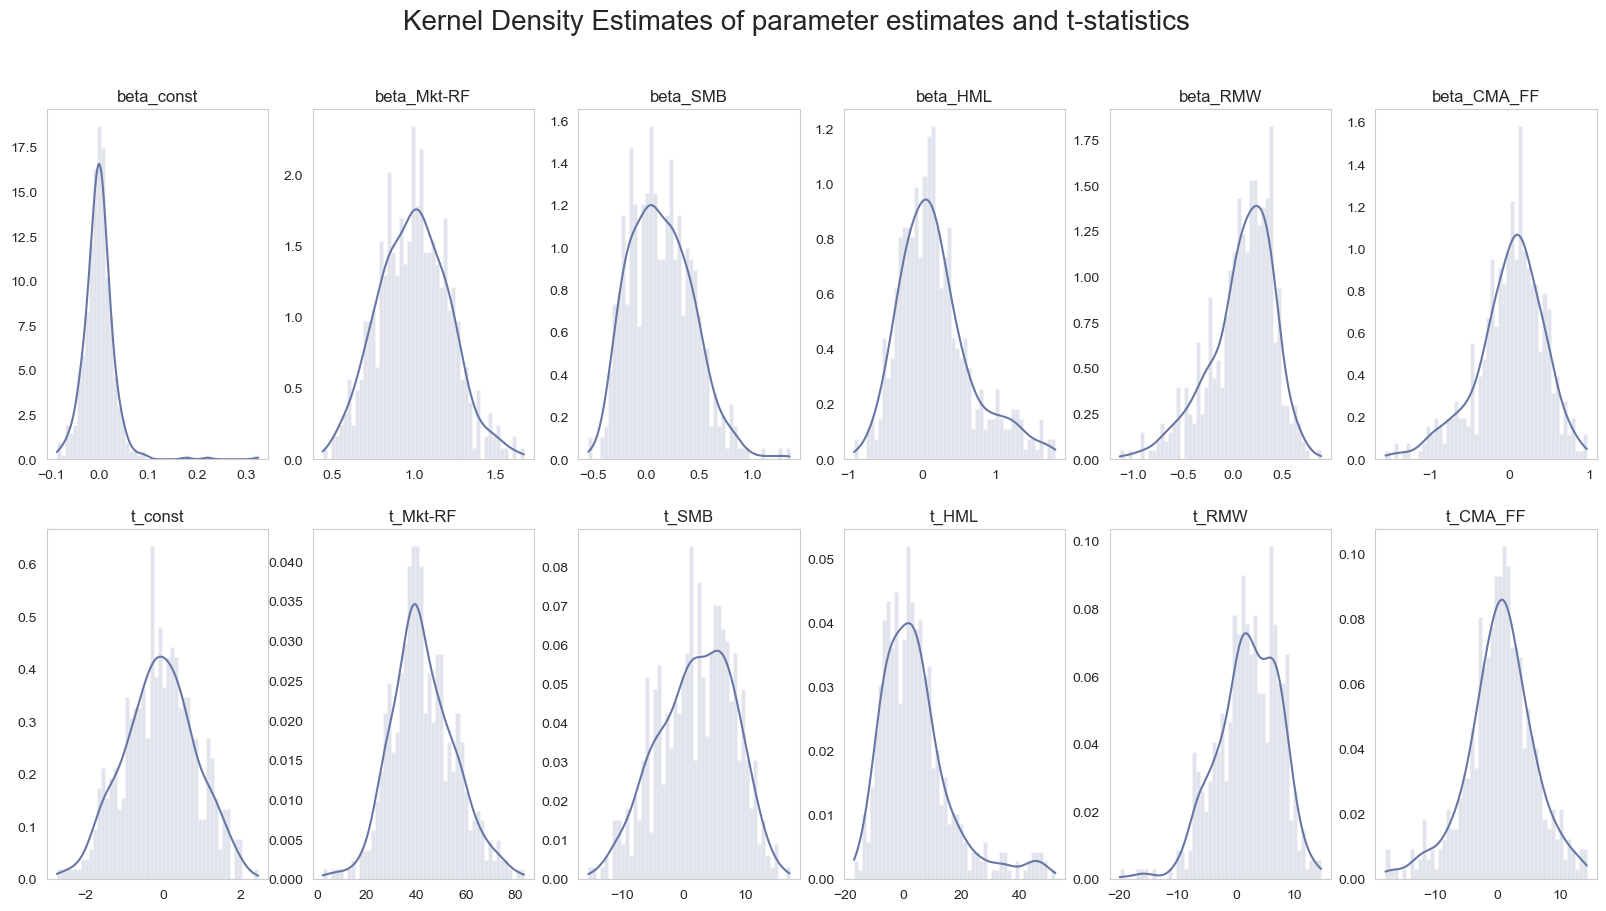

In [23]:
# Create histograms of estimate and every t-statistic
fig, axs = plt.subplots(2, 6, figsize = (20, 10))
axs = axs.reshape(-1)
colnames = df_ols_results.columns[1:]

for i, ax in enumerate(axs):
    if i >= len(colnames):
        break
    vals = df_ols_results.iloc[:,1+i]
    d = stats.gaussian_kde(vals)
    ind = np.linspace(min(vals),max(vals),500)
    kdepdf = d.evaluate(ind)
    ax.plot(ind, kdepdf, label='Kernel Density Estimator', color = DARK_COL)
    ax.hist(vals, density = True, bins = 50, color = DARK_COL, alpha = 0.2)
    #ax.legend()
    ax.grid(False)
    ax.set_title(colnames[i])
plt.suptitle("Kernel Density Estimates of parameter estimates and t-statistics", size = 20)
plt.show()

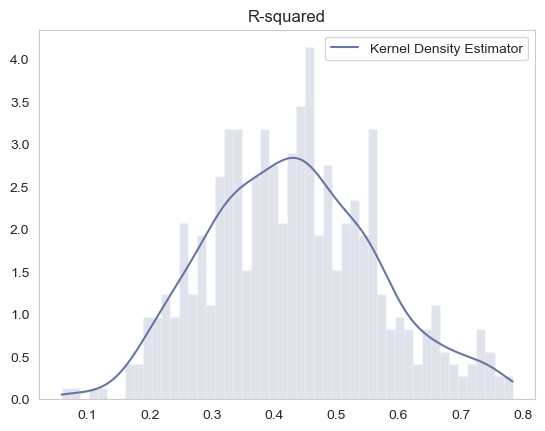

In [24]:
# Plot R-squared
vals = df_ols_results["R2"]
d = stats.gaussian_kde(vals)
ind = np.linspace(min(vals),max(vals),500)
kdepdf = d.evaluate(ind)
plt.plot(ind, kdepdf, label='Kernel Density Estimator', color = DARK_COL)
plt.hist(vals, density = True, bins = 50, color = DARK_COL, alpha = 0.2)
plt.legend()
plt.grid(False)
plt.title("R-squared")
plt.show()

**Comment:** From these plots we can make the following observations.

First of all, a lot of the coefficient estimates of the FF-factors seem to statistically significant. The factor that is clearly the most important is $R_m - R_f$, with the t-statistic distribution having a mean of around 40. This means that in almost all cases the market factor has a positive impact on the stock returns. Furthermore we observe that the t-statistics are generally greater (in absolute value) than 1.96, which means that we reject the hypothesis that the factors have no impact on the excess returns. Indeed, the t-statistics for SMB, HML, RMW and CMA have a large range (on average -15 to 15) with a distribution that is fairly normal.

In fact we observe that most parameter estimates seem to be relatively normally distributed, with the exception of HML and RMW, which have a parameter distribution that is skewed to the right and left respectively. Since the corresponding t-statistics are merely a scaled version of the parameter estimates, it is not surprising that most t-statistics are normally distributed as well.

The R-squared distribution estimate looks fairly normal, with a mean of around 0.4. That indicates that the FF-factors can explain (on average) 40% of the total variance of excess returns.

# 4. How differ the estimated factor coefficients according to the 11 sectors of the Global Industry Classification Standard?

In [13]:
def add_sector(df):
    df = df.copy()
    stocks = df["stock"]
    df["sector"] = ""
    for i, stock in enumerate(tqdm.tqdm(stocks)):
        ticker = yf.Ticker(stock)
        try:
            sector = ticker.get_info()["sector"]
        except KeyError:
            print(f"No sector found for {stock}")
        df.iloc[i, -1] = sector
    return df

In [14]:
df_results_sector = add_sector(df_ols_results)

 16%|█▌        | 79/500 [00:12<01:04,  6.57it/s]

No sector found for CAT


 54%|█████▍    | 271/500 [00:42<00:34,  6.68it/s]

No sector found for L


100%|██████████| 500/500 [01:18<00:00,  6.34it/s]


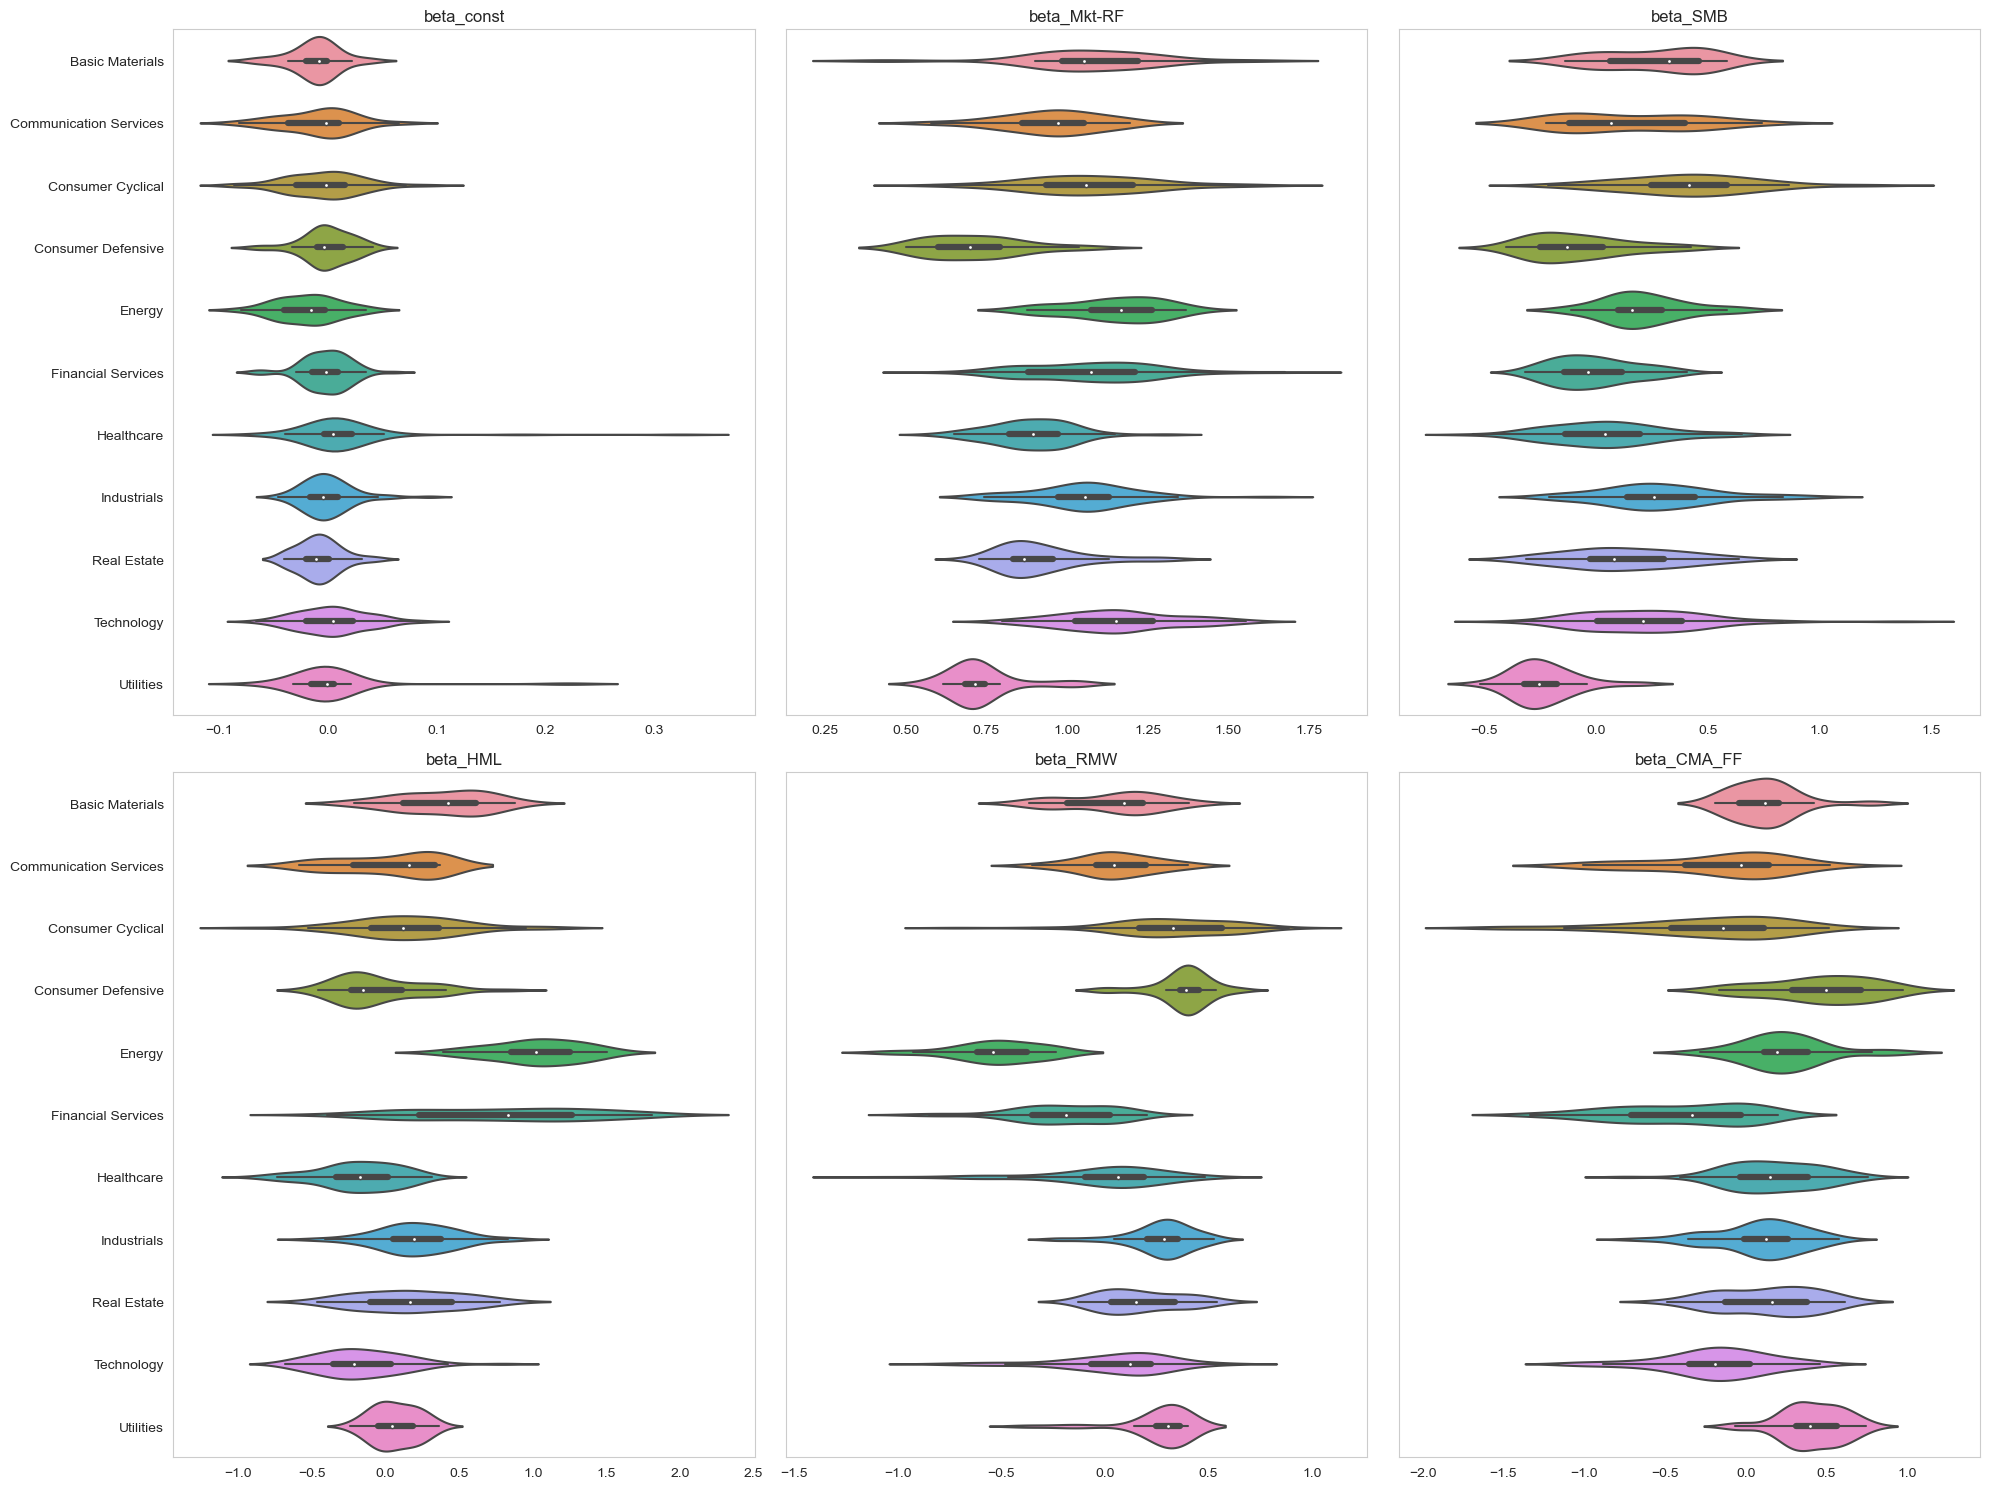

In [21]:
def plot_violin_sector(df):
    sns.set_style("whitegrid")
    # Create histograms of estimates for every industry
    fig, axs = plt.subplots(2, 3, figsize = (20, 15), sharey=True, squeeze=True)
    #plt.close('all')
    axs = axs.reshape(-1)
    coef_names = df_ols_results.columns[1:(len(axs)+1)]
    

    for i, ax in enumerate(axs):
        D = pd.pivot(df_results_sector[[coef_names[i], "sector"]],columns='sector', values=coef_names[i])
        sns.violinplot(D, widths=2, showmeans=True, showmedians=False, showextrema=False, orient = "h", ax=ax)
        ax.set_ylabel("")
        ax.grid(False)
        ax.set_title(coef_names[i])
    plt.tight_layout()
    

plot_violin_sector(df_ols_results)

**Comment** 

In these plots we can observe the distribution of the distribution of each coefficient for every sector. For the constant we do not observe a considerable difference. That being said, for the other coefficients, we observe differences among all sectors. For instance, for the market factor, we see that consumer cyclical and utilies are less influenced by the market, whereas sectors like Energy and Technology are heavily market-influenced with an average coefficient above 1. That being said, we observe that all sectors are positively influenced by the market.

# ADD COMMENT

In [16]:
def plot_kde_sector(df):
    # Create histograms of estimates for every industry
    fig, axs = plt.subplots(2, 3, figsize = (20, 15))
    axs = axs.reshape(-1)
    coef_names = df_ols_results.columns[1:(len(axs)+1)]
    sns.set_style("whitegrid")


    for sector in df["sector"].unique():
        df_sector = df_ols_results[df_ols_results["sector"] == sector]
        for i, ax in enumerate(axs):
            vals = df_sector.iloc[:,i+1]
            d = stats.gaussian_kde(vals)
            ind = np.linspace(min(vals)-0.2,max(vals) + 0.3,500)
            kdepdf = d.evaluate(ind)
            ax.plot(ind, kdepdf, label=sector)
            #ax.hist(vals, density = True, bins = 50, color = DARK_COL, alpha = 0.2)
            ax.legend()
            ax.grid(False)
            ax.set_title(coef_names[i])
            #plt.title("R-squared")
            #plt.show()

# 5. Is it possible to cluster the stocks in groups in an unsupervised way? How many clusters do you recommend and what are typical characteristics of each cluster.

## 5.1 Clustering based on FF-coefficients

In [47]:
df_ff_clustering = df_ols_results.copy()
cols_of_interest = df_ols_results.columns[:13]
df_ff_clustering = df_ff_clustering[cols_of_interest]
df_ff_clustering.index = df_ff_clustering["stock"].values
df_ff_clustering = df_ff_clustering.drop("stock", axis = 1)
df_ff_clustering

,beta_const,beta_Mkt-RF,beta_SMB,beta_HML,beta_RMW,beta_CMA_FF,t_const,t_Mkt-RF,t_SMB,t_HML,t_RMW,t_CMA_FF
A,-0.002305,1.147959,0.042657,-0.177300,-0.233549,0.126152,-0.109378,57.002644,1.119693,-4.897154,-4.606566,1.814011
AAL,-0.026688,1.273090,0.834769,0.770070,0.242065,-0.354722,-0.558791,27.894740,9.668787,9.385563,2.106811,-2.250749
AAP,-0.015915,0.842018,0.328667,0.037590,0.583784,0.039669,-0.533398,29.532885,6.093729,0.733363,8.133306,0.402918
AAPL,0.025276,1.178569,-0.175437,-0.497186,0.595588,-0.023429,1.187734,57.955237,-4.560393,-13.599527,11.633607,-0.333638
ABBV,0.028364,0.791503,-0.140691,-0.128710,0.082056,0.368703,0.967089,28.303809,-2.715757,-2.667294,1.187542,3.975103
...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,0.007844,0.855560,-0.030755,0.042028,0.327986,0.066486,0.371545,42.407790,-0.805839,1.158782,6.457753,0.954339
ZBH,-0.018393,0.860477,0.193155,0.166984,0.117460,-0.168359,-0.829152,40.593155,4.816850,4.381829,2.201078,-2.299990
ZBRA,0.005819,1.202005,0.416916,-0.265489,0.188217,-0.103430,0.193632,41.857025,7.674556,-5.142510,2.603470,-1.043000
ZION,-0.003125,1.049921,0.337522,1.631794,-0.552389,-0.945908,-0.130750,45.974140,7.812697,39.745610,-9.607997,-11.994489


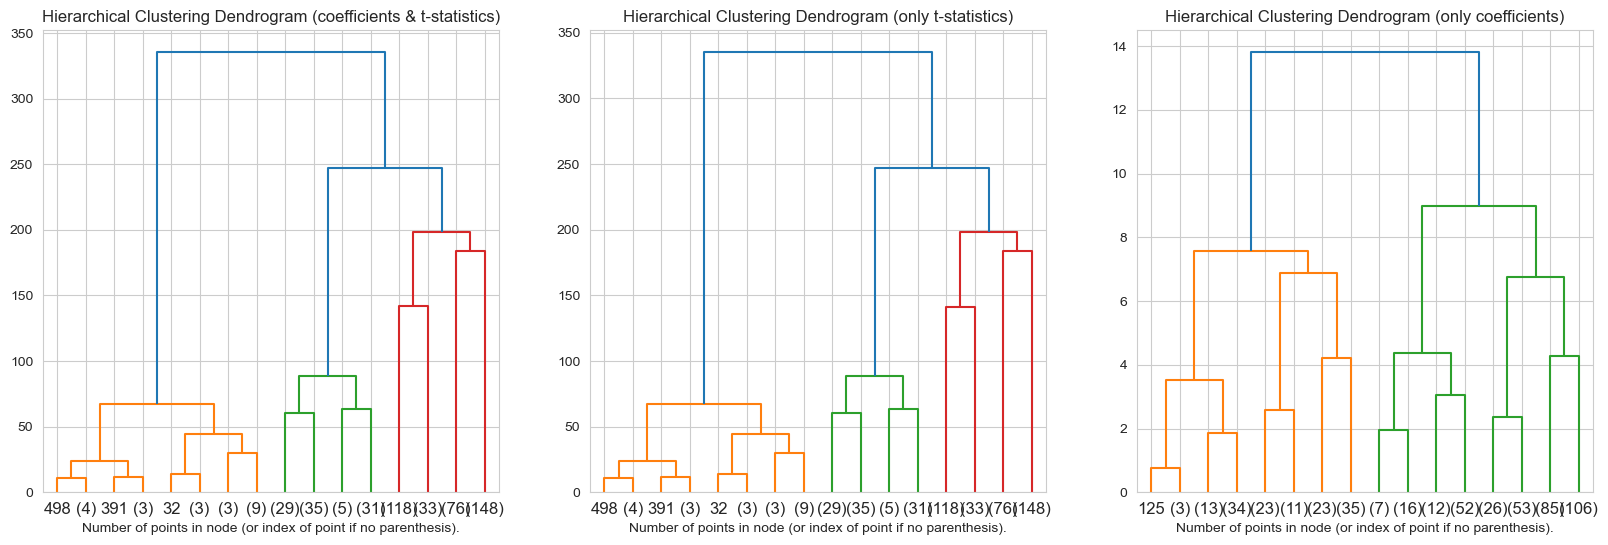

In [66]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)



colranges = [(1, 13), (7,13), (1,7)]
titles = ["(coefficients & t-statistics)", "(only t-statistics)", "(only coefficients)"]
fig, axs = plt.subplots(1, 3, figsize = (20, 6))
coef_names = df_ols_results.columns[1:(len(axs)+1)]
sns.set_style("whitegrid")
for i, (ax, (col_min, col_max)) in enumerate(zip(axs,colranges)):
    df_ff_clustering = df_ols_results.copy()
    cols_of_interest = df_ols_results.columns[col_min:col_max]
    df_ff_clustering = df_ff_clustering[cols_of_interest]

    # setting distance_threshold=0 ensures we compute the full tree.
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

    model = model.fit(df_ff_clustering)
    ax.set_title(f"Hierarchical Clustering Dendrogram {titles[i]}")
    # plot the top three levels of the dendrogram
    plot_dendrogram(model, truncate_mode="level", p=3, ax= ax)
    ax.set_xlabel("Number of points in node (or index of point if no parenthesis).")

## Clustering based on features extracted from returns time series

In [70]:
returns.fillna(0)

,Date,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
0,2010-01-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2010-01-05,-1.092223,10.724573,-0.596086,0.172755,0.000000,-0.716037,-0.811254,-0.334110,0.616112,...,5.904136,-1.193024,0.389710,-1.195954,0.000000,-0.342566,3.116542,-0.174548,3.465116,0.000000
2,2010-01-06,-0.355927,-4.231421,0.868204,-1.603397,0.000000,-0.950057,0.553847,-0.433244,1.057464,...,-1.320371,0.191839,0.860590,0.656688,0.000000,-0.717495,-0.032311,-0.771667,8.338190,0.000000
3,2010-01-07,-0.129704,2.904349,-0.024744,-0.185038,0.000000,-1.616647,0.824997,-0.589966,-0.093564,...,2.113127,-0.432180,-0.314723,1.300556,0.000000,-0.028801,2.268106,-2.531778,10.616014,0.000000
4,2010-01-08,-0.032500,-1.926830,0.394430,0.662630,0.000000,1.080672,0.509940,-0.197437,-0.398529,...,-0.719062,0.048104,-0.401919,0.000000,0.000000,0.028801,-2.122816,-0.325557,-1.631954,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3329,2023-03-27,0.837650,1.590773,3.467113,-1.236952,-0.304236,0.178861,0.417280,0.498369,0.717993,...,-0.225442,-0.397436,2.168911,0.748858,0.828295,0.359200,-0.031742,0.045006,3.751748,0.927596
3330,2023-03-28,-0.331202,0.286533,0.867762,-0.398826,0.449672,0.832565,-1.380599,0.645697,0.378905,...,0.814805,0.168338,1.239921,0.584490,0.561740,0.163563,0.301711,0.445592,2.091842,-0.405149
3331,2023-03-29,0.915649,2.612226,1.551751,1.959749,-0.158096,0.612047,1.542968,1.470951,1.780423,...,1.701700,1.728100,1.703109,-0.079490,1.499161,-0.070061,0.474533,2.036675,3.574739,-1.452560
3332,2023-03-30,0.477010,0.832759,0.897704,0.984129,-0.050655,0.232478,0.465358,0.088453,0.966943,...,-0.045864,0.554520,0.485234,2.574346,0.902496,0.713899,0.015782,4.293239,-2.412903,0.911838


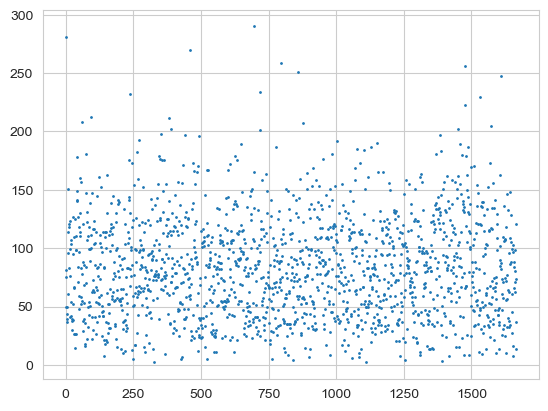

In [99]:
from scipy.fft import fft

stocks = returns.columns[1:] # Excludes Date
X = returns[stocks].fillna(0)
ys = []
for i, stock in enumerate(stocks):
    vals = X[stock].to_numpy()
    y = fft(vals)
    ys.append(y)
ys = np.array(ys)
intensity_freqs = abs(ys)[:, :ys.shape[1]//2]
y = intensity_freqs[111]
plt.scatter(range(len(y)), y, s = 1)
plt.show()

## Clustering based on raw returns time series

In [ ]:
stocks = returns.columns[1:] # Excludes Date
X = df[stocks]

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS,y
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10
1,-1.092223,10.724573,-0.596086,0.172755,0.172755,-0.716037,-0.811254,-0.334110,0.616112,1.631272,...,-1.193024,0.389710,-1.195954,-1.195954,-0.342566,3.116542,-0.174548,3.465116,3.465116,1
2,-0.355927,-4.231421,0.868204,-1.603397,-1.603397,-0.950057,0.553847,-0.433244,1.057464,-0.212432,...,0.191839,0.860590,0.656688,0.656688,-0.717495,-0.032311,-0.771667,8.338190,8.338190,1
3,-0.129704,2.904349,-0.024744,-0.185038,-0.185038,-1.616647,0.824997,-0.589966,-0.093564,-1.959530,...,-0.432180,-0.314723,1.300556,1.300556,-0.028801,2.268106,-2.531778,10.616014,10.616014,1
4,-0.032500,-1.926830,0.394430,0.662630,0.662630,1.080672,0.509940,-0.197437,-0.398529,-0.543629,...,0.048104,-0.401919,0.000000,0.000000,0.028801,-2.122816,-0.325557,-1.631954,-1.631954,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3329,0.837650,1.590773,3.467113,-1.236952,-0.304236,0.178861,0.417280,0.498369,0.717993,-0.483886,...,-0.397436,2.168911,0.748858,0.828295,0.359200,-0.031742,0.045006,3.751748,0.927596,1
3330,-0.331202,0.286533,0.867762,-0.398826,0.449672,0.832565,-1.380599,0.645697,0.378905,0.066975,...,0.168338,1.239921,0.584490,0.561740,0.163563,0.301711,0.445592,2.091842,-0.405149,10
3331,0.915649,2.612226,1.551751,1.959749,-0.158096,0.612047,1.542968,1.470951,1.780423,1.530807,...,1.728100,1.703109,-0.079490,1.499161,-0.070061,0.474533,2.036675,3.574739,-1.452560,1
3332,0.477010,0.832759,0.897704,0.984129,-0.050655,0.232478,0.465358,0.088453,0.966943,0.720049,...,0.554520,0.485234,2.574346,0.902496,0.713899,0.015782,4.293239,-2.412903,0.911838,10


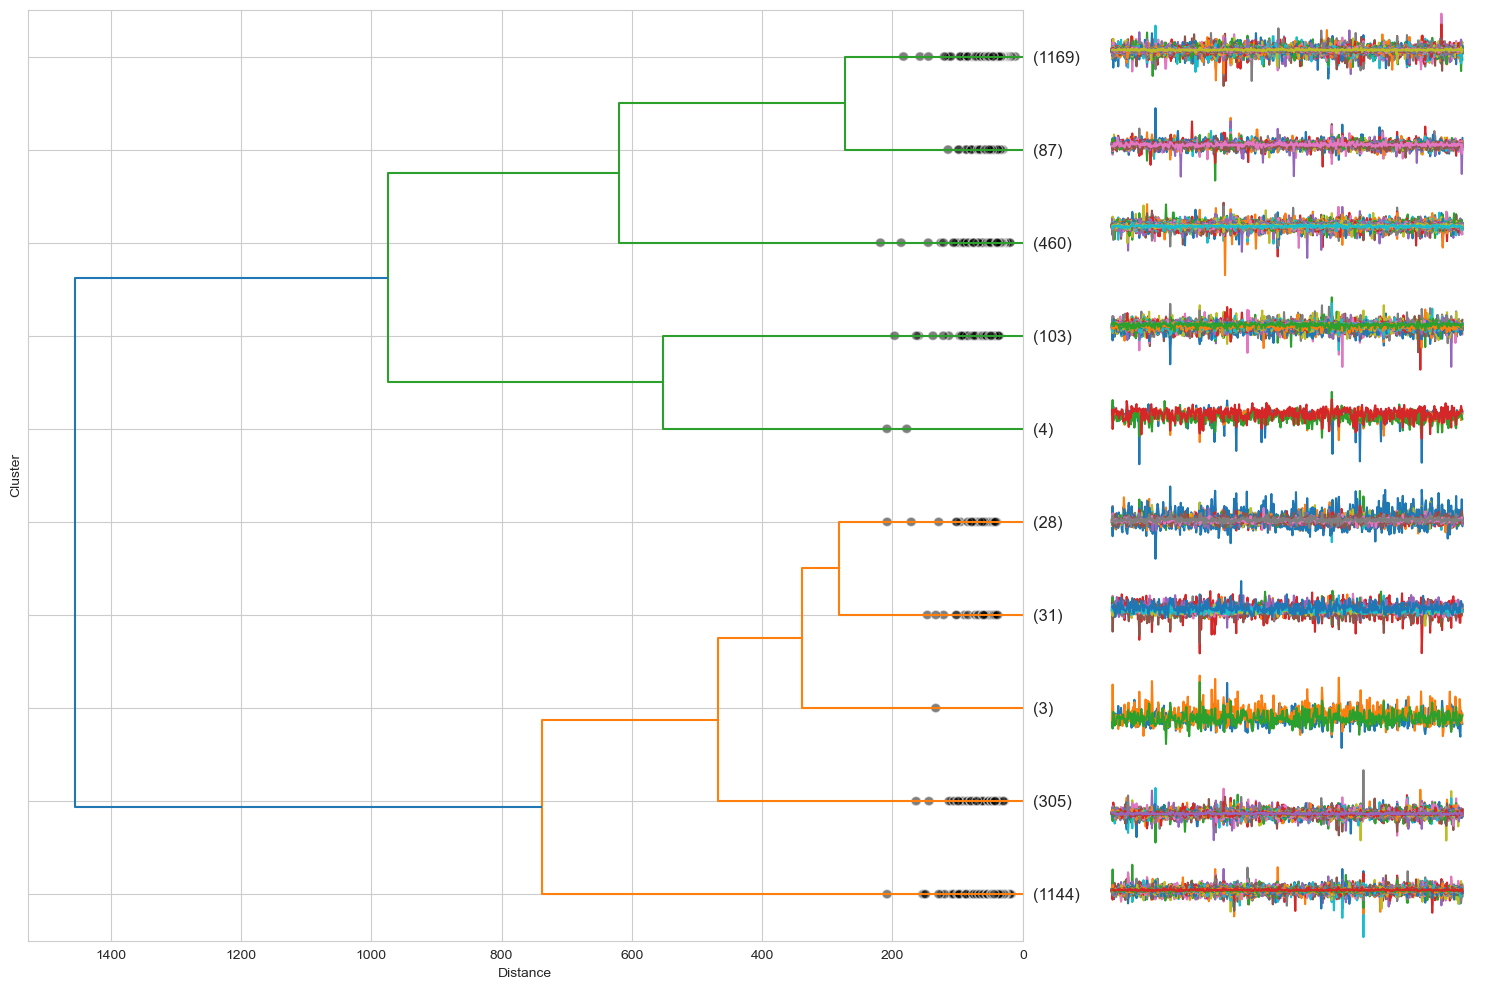

In [ ]:
from dendrogram_ts import maxclust_draw

sns.set_style('whitegrid')
plt.figure(figsize=(15,10));

maxclust_draw(X.fillna(method="ffill", axis = 1), 'ward', metric= "euclidean", max_cluster=10, ts_hspace=3)